# CSE 519: Data Science

## Exploratory Data Analysis in iPython (Kaggle New York City Taxi Fare Prediction)
---
Author: Sagar Gurtu <br/>

---
### Task 1

1. Initializing the environment and importing the necessary modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgbm
import math

2. We'll read the training data and parse the pickup dates,

In [2]:
df = pd.read_csv('train.csv', nrows = 7500000, parse_dates = ["pickup_datetime"])

3. Drop the NaN values from dataset

In [3]:
df = df.dropna(how = 'any', axis = 'rows')

4. The minimum fare amount charged (without tips) as per [NYC Fare Rate](http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml) should be 
<br/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; = Base Fare + State Surcharge + Improvement Fare = $\$$2.5 + $\$$0.50 + $\$$0.30 = $\$$3.30
<br/> On the other hand, the data also contains taxi ride information for years before the base fare was changed (it was $\$$2 previously) and extra surcharges were added. Since fare amount in the data cannot be lower than this minimum amount, data is filtered to get rows having fare amount &#8805; $\$$2.

In [4]:
df = df[df.fare_amount >= 2]

5. According to [NYC Resources FAQ](https://www1.nyc.gov/nyc-resources/faq/484/how-many-passengers-are-allowed-in-a-taxi), the maximum passenger count can be 6. Therefore, the data is filtered for passengers greater than 0 and less than 7.

In [5]:
df = df[(df.passenger_count > 0) & (df.passenger_count < 7)]

6. Some of the coordinate data contains 0 values. Since NYC is not located at coordinates (0lat, 0lon) and distances cannot be calculated using this data, these rows can be removed. Moreover, the city of New York is bounded by the coordinates 40 to 41.5 latitude and -74.5 to -73 longitude. Here, we're removing those coordinates well beyond the city limits because although the taxi can go outside NYC, the fare is a flat rate agreed upon between the driver and passenger at the start of the trip (see [FAQ](https://www1.nyc.gov/nyc-resources/faq/488/how-much-does-it-cost-to-take-a-taxi-beyond-the-limits-of-new-york-city)). Also, there are rows where pickup and dropoff coordinates are the same. This maybe due to round trip or something like that. Since, total distances cannot be measured using this, we will remove these rows for now.

In [6]:
df = df[(df.pickup_latitude >= 40) & (df.pickup_latitude <=41.5)]
df = df[(df.dropoff_latitude >= 40) & (df.dropoff_latitude <=41.5)]
df = df[(df.pickup_longitude >= -74.5) & (df.pickup_longitude <=-73)]
df = df[(df.dropoff_longitude >= -74.5) & (df.dropoff_longitude <=-73)]
df = df[(df.pickup_latitude != df.dropoff_latitude) & (df.pickup_longitude != df.dropoff_longitude)]

7. Now, lets look at the dataset statistics

In [7]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,7.234467e+06,7.234467e+06,7.234467e+06,7.234467e+06,7.234467e+06,7.234467e+06
mean,1.132748e+01,-7.397549e+01,4.075094e+01,-7.397462e+01,4.075132e+01,1.690526e+00
std,9.605704e+00,3.591110e-02,2.793448e-02,3.499423e-02,3.134803e-02,1.305907e+00
min,2.000000e+00,-7.449954e+01,4.000684e+01,-7.449994e+01,4.000000e+01,1.000000e+00
25%,6.000000e+00,-7.399230e+01,4.073657e+01,-7.399159e+01,4.073561e+01,1.000000e+00
50%,8.500000e+00,-7.398213e+01,4.075336e+01,-7.398064e+01,4.075389e+01,1.000000e+00
75%,1.250000e+01,-7.396848e+01,4.076753e+01,-7.396554e+01,4.076840e+01,2.000000e+00
max,9.520000e+02,-7.300002e+01,4.149911e+01,-7.300116e+01,4.150000e+01,6.000000e+00


8. Using the coordinates, we can calculate the distances travelled by the taxi. Euclidean distance between any two points in a cartesian coordinate system is:
$\sqrt{(x_2-x_1)^2 + (y_2-y_1)^2}$ where the points are $(x_1, y_1)$ and $(x_2, y_2)$

In [8]:
def euclidean_distance(row):
    x1 = row.pickup_latitude
    y1 = row.pickup_longitude
    x2 = row.dropoff_latitude
    y2 = row.dropoff_longitude
    
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)

9. Now, we'll add the euclidean distance as a new column in our data set.

In [9]:
df['euclidean_distance'] = df.apply (lambda row: euclidean_distance(row), axis = 1)

10. Since, it is a geographical coordinate system and not a cartesian system, we'll compute the Haversine distance (see [Haversine Formula](https://en.wikipedia.org/wiki/Haversine_formula)) which gives the true distance between two points on a sphere.

In [10]:
def haversine_distance(row):
    lat1 = row.pickup_latitude
    lon1 = row.pickup_longitude
    lat2 = row.dropoff_latitude
    lon2 = row.dropoff_longitude
     
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    a = math.sin((lat2 - lat1)/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin((lon2 - lon1)/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 3959  #miles
    return c * r

11. Adding the haversine distance (in miles) to the data set,

In [11]:
df['haversine_distance'] = df.apply (lambda row: haversine_distance(row), axis = 1)

In [12]:
df['haversine_distance'].describe()

count    7.234467e+06
mean     2.091624e+00
std      2.347497e+00
min      8.648332e-05
25%      7.948818e-01
50%      1.353023e+00
75%      2.449760e+00
max      8.259279e+01
Name: haversine_distance, dtype: float64

12. Now, lets look at the fare amounts

In [13]:
df['fare_amount'].describe()

count    7.234467e+06
mean     1.132748e+01
std      9.605704e+00
min      2.000000e+00
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      9.520000e+02
Name: fare_amount, dtype: float64

13. It can be seen that the maximum fare is quite large as compared to the 75% quartile. Looking at the rows for such large fares, we can notice that the fares for even small distances (<=1 mile) are quite large.

In [14]:
print df[df['fare_amount'] > 300]

                                   key  fare_amount     pickup_datetime  \
233874     2012-10-28 14:14:44.0000001       450.00 2012-10-28 14:14:44   
287638     2015-03-11 16:25:21.0000007       450.00 2015-03-11 16:25:21   
329010   2011-07-29 14:19:00.000000200       450.00 2011-07-29 14:19:00   
361793    2011-05-05 08:39:00.00000018       400.00 2011-05-05 08:39:00   
451974     2011-10-08 05:17:04.0000002       400.00 2011-10-08 05:17:04   
951810     2015-03-24 17:14:27.0000001       347.54 2015-03-24 17:14:27   
1004275    2012-02-02 23:52:37.0000004       325.00 2012-02-02 23:52:37   
1215047   2011-09-08 00:32:00.00000020       488.00 2011-09-08 00:32:00   
1950951   2011-04-18 00:25:00.00000053       430.00 2011-04-18 00:25:00   
1961485  2014-04-28 14:32:00.000000132       315.00 2014-04-28 14:32:00   
2380175    2014-05-28 08:41:32.0000003       353.33 2014-05-28 08:41:32   
3206977    2015-02-03 14:50:22.0000003       542.83 2015-02-03 14:50:22   
3316931    2012-12-14 04:

14. We can calculate an upper bound on the fare amount for 1 mile haversine distance and use it to remove outliers. According to [NYC Fare Rate](https://www1.nyc.gov/nyc-resources/service/1271/yellow-taxi-fares), an estimate maximum upper bound (extremely worst case) on 1 mile distance would be <br/>
    = Standard Fare Rate + Every Fifth of mile rate + Less than 12 miles per hour rate + Night Surcharge + Weekday Surcharge<br/>
    = $\$$3.30 + 5 \* $\$$0.50 + 60 \* $\$$0.50 + $\$$1.00 + $\$$0.50
    $\approx$ $\$$100 (extremely worst case)
    
Lets see how many rows are there where distance travelled is less than or equal to 1 mile and fare amount is greater than \$100

In [15]:
print len(df[(df['haversine_distance']<=1) & (df['fare_amount']>100)])

492


15. Dropping these rows,

In [16]:
df = df.drop(df[(df['haversine_distance']<=1) & (df['fare_amount']>100)].index)

---
### Task 2

**Correlation between Euclidean distance and taxi fare**

Calulating pearson correlation coefficients using numpy,

In [17]:
np.corrcoef(df.euclidean_distance, df.fare_amount)[0, 1]

0.8518733801516434

In [18]:
np.corrcoef(df.haversine_distance, df.fare_amount)[0, 1]

0.8435406884693127

**Correlation between time of the day and Euclidean distance**<br/>
For time of the day, we first need to extract the time from pickup_datetime and create a new column for it.

In [19]:
df['pickup_time'] = df.apply (lambda row: row.pickup_datetime.time(), axis = 1)

To calculate correlation between time of the day and distance travelled, we would first convert the time to its decimal representation. Here, we would consider decimal representation as number of hours elapsed since the day started.

In [20]:
def time_in_hours(t):
    st = t.strftime('%H:%M:%S')
    (h, m, s) = st.split(':')
    return float(h) + float(m) / 60 + float(s) / 3600

Adding a column for time of the day in hours elapsed,

In [21]:
df['pickup_time_hours'] = df.apply (lambda row: time_in_hours(row.pickup_time), axis = 1)

The Pearson Correlation coefficient between time of the day and euclidean distance is given by,

In [22]:
np.corrcoef(df.pickup_time_hours, df.euclidean_distance)[0, 1]

-0.028971437199770064

**Correlation between time of the day and taxi fare**<br/>
The Pearson Correlation coefficient between time of the day and fare amount is given by,

In [23]:
np.corrcoef(df.pickup_time_hours, df.fare_amount)[0, 1]

-0.017431284134379256

---
### Task 3

**Scatter Plot between euclidean distance and taxi fare**

[Text(0,0.5,'Fare'),
 Text(0.5,0,'Euclidean Distance'),
 Text(0.5,1,'Euclidean Distance vs Fare')]

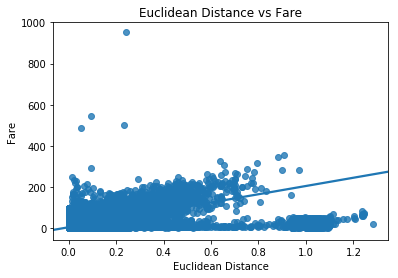

In [24]:
sns.regplot(x = 'euclidean_distance', y = 'fare_amount', data = df).set(xlabel='Euclidean Distance', ylabel='Fare',title='Euclidean Distance vs Fare')

**Scatter Plot between haversine distance and taxi fare**

[Text(0,0.5,'Fare'),
 Text(0.5,0,'Haversine Distance (miles)'),
 Text(0.5,1,'Haversince Distance vs Fare')]

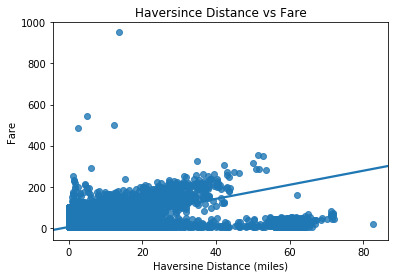

In [25]:
sns.regplot(x = 'haversine_distance', y = 'fare_amount', data = df).set(xlabel='Haversine Distance (miles)', ylabel='Fare',title='Haversine Distance vs Fare')

The distance and the fare amount seem to be positively correlated. This is obvious since the fare amount includes a charge depending upon the distance traveled. Looking at the scatter plot, some outlier data points can be seen. For example, there is a fare amounting to nearly $\$$970 for a 15 mile distance. This may be noise or it may have happened due to traffic signals, slow speeds, traffic jams etc. Moreover, we can see that there are some extremely low fares for far away distances. Some of these may be outliers/bad data or on the other hand, the passenger may have used some discount coupon.



**Plot between time of day and euclidean distance**

[Text(0,0.5,'Euclidean Distance'),
 Text(0.5,0,'Time of the Day'),
 Text(0.5,1,'Time of Day vs Euclidean Distance')]

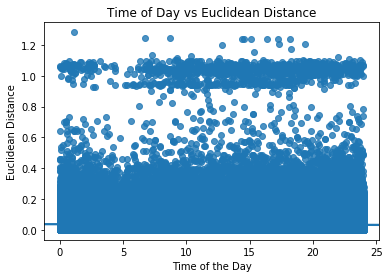

In [26]:
sns.regplot(x = 'pickup_time_hours', y = 'euclidean_distance', data = df).set(xlabel='Time of the Day', ylabel='Euclidean Distance',title='Time of Day vs Euclidean Distance')

The pickup time of the day and the distance traveled does not seem to be correlated. It can be seen that people do not tend to travel far away distances between around 3am to 6am. Also, as compared to longer distances, the number of short trips are really high.

**Plot between time of day and taxi fare**

[Text(0,0.5,'Fare'),
 Text(0.5,0,'Time of the Day'),
 Text(0.5,1,'Time of day vs Fare')]

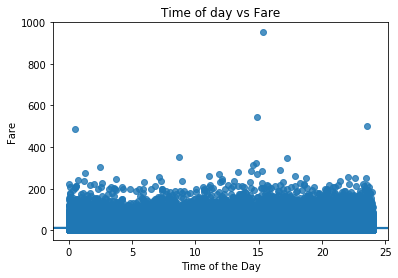

In [27]:
sns.regplot(x = 'pickup_time_hours', y = 'fare_amount', data = df).set(xlabel='Time of the Day', ylabel='Fare',title='Time of day vs Fare')

The pickup time and the fare amount does not seem to be correlated. In the plot, it can be seen that fare amounts touch above $\$$400. These may be outliers or far away distances.

---
### Task 4

Let's create a box plot for passenger count

[Text(0,0.5,'Passenger Count'), Text(0.5,1,'Passenger Count')]

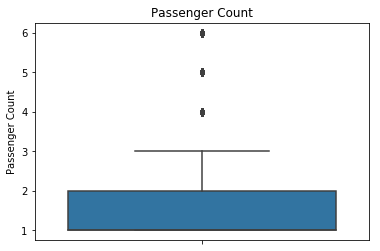

In [28]:
sns.boxplot(y = 'passenger_count', data = df).set(ylabel='Passenger Count',title='Passenger Count')

Here, we can see that most of the taxi rides consisted of just 1 or 2 passengers.

Plotting passenger count vs the distance travelled,

[Text(0,0.5,'Haversine Distance'),
 Text(0.5,0,'Passenger Count'),
 Text(0.5,1,'Passenger Count vs Haversine Distance (miles)')]

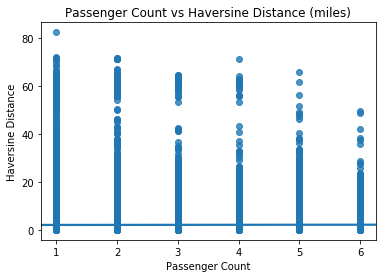

In [29]:
sns.regplot(x = 'passenger_count', y = 'haversine_distance', data = df).set(xlabel='Passenger Count', ylabel='Haversine Distance',title='Passenger Count vs Haversine Distance (miles)')

This shows that the rides with 4 or more passengers did not travel long distances as compared to rides with fewer passengers.

Let's plot a distribution for the fare amount,

[Text(0.5,0,'Fare Amount'), Text(0.5,1,'Distribution of Fare')]

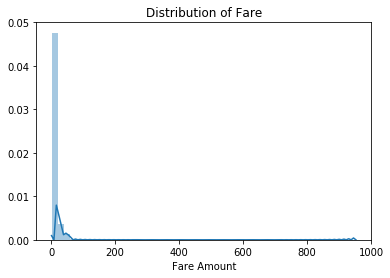

In [30]:
sns.distplot(df['fare_amount']).set(xlabel='Fare Amount',title='Distribution of Fare')

Most of the fare amounts seem to be < $\$$40. There appears to be a small spike towards the end of the distribution which mostly would be outliers.

---
### Task 5

We'll split the pickup datetime into years, months, week and day

In [31]:
df['pickup_year'] = df.apply (lambda row: row.pickup_datetime.year, axis = 1)

In [33]:
df['pickup_month'] = df.apply (lambda row: row.pickup_datetime.month, axis = 1)

In [34]:
df['pickup_weekday'] = df.apply (lambda row: row.pickup_datetime.weekday(), axis = 1)

In [35]:
df['pickup_day'] = df.apply (lambda row: row.pickup_datetime.day, axis = 1)

Let's use the above features for finding some additional information.

From the below plot, there does not seem to be much difference in number of passengers per ride over the years except for the 6 passengers per ride bin which has slightly increased.

[Text(0,0.5,'Frequency'),
 Text(0.5,0,'Pickup Year'),
 Text(0.5,1,'Frequency of Passenger Count Per Ride For Each Year')]

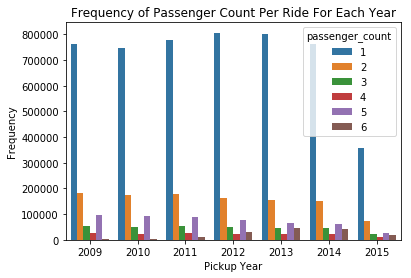

In [36]:
sns.countplot(x="pickup_year", hue="passenger_count", data=df).set(xlabel='Pickup Year', ylabel='Frequency',title='Frequency of Passenger Count Per Ride For Each Year')

Also, it can be seen that over the years, the number of higher fare rides have very slightly increased,

[Text(0,0.5,'Fare'),
 Text(0.5,0,'Pickup Year'),
 Text(0.5,1,'Pickup Year vs Fare')]

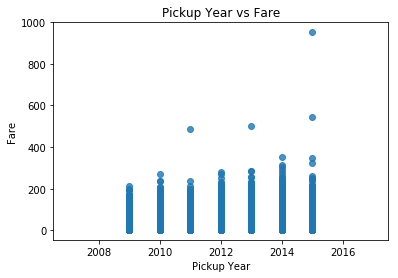

In [37]:
sns.regplot(x = 'pickup_year', y = 'fare_amount', data = df, fit_reg=False).set(xlabel='Pickup Year', ylabel='Fare',title='Pickup Year vs Fare')

We can also create a column stating if it is night time for taking it's surcharge into account.

In [38]:
df['night'] = df.apply (lambda row: (1 if (row.pickup_time_hours>=20 or row.pickup_time_hours<8) else 0), axis = 1)

[Text(0,0.5,'Frequency'),
 Text(0.5,0,'Is Night Ride?'),
 Text(0.5,1,'Frequency of Daytime and Nighttime rides')]

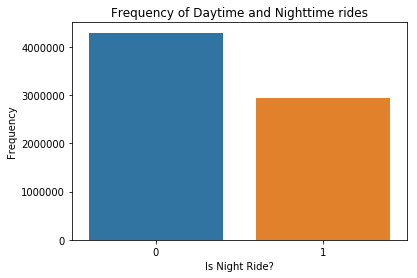

In [39]:
sns.countplot(x="night", data=df).set(xlabel='Is Night Ride?', ylabel='Frequency', title='Frequency of Daytime and Nighttime rides')

There were more day time rides than night.

Plotting correlation of fare amount with all other features, we see that it is highly correlated with distance features and very weakly related to separated date time features.

Text(0.5,1,'Correlation with Fare Amount')

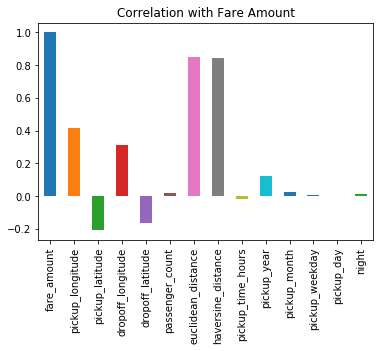

In [40]:
df.corr()['fare_amount'].plot.bar().set_title('Correlation with Fare Amount')

---
### Task 6

1. The following code creates a simple linear regression model

In [150]:
lm = linear_model.LinearRegression()

2. We'll have a look at all the columns existing and created so far

In [151]:
df.dtypes

key                           object
fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
euclidean_distance           float64
haversine_distance           float64
pickup_time                   object
pickup_time_hours            float64
pickup_year                    int64
pickup_month                   int64
pickup_weekday                 int64
pickup_day                     int64
night                          int64
dtype: object

3. Dropping unnecessary columns and creating dataframe for modelling,

In [152]:
X = df.drop(['key','pickup_datetime','fare_amount','passenger_count','pickup_time'], axis = 1)

4. Splitting the dataset into training and test data,

In [153]:
X_train, X_test, Y_train, Y_test = train_test_split(X, df.fare_amount, test_size=0.1, random_state=123)  #split is 90:10

5. Train the model using training sets,

In [154]:
lm.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

6. Print the scores, coefficients, intercept

In [155]:
lm.score(X_train, Y_train)

0.7470554222117534

In [156]:
lm.score(X_test, Y_test)

0.7368730454051191

In [157]:
lm.intercept_

-51.53359484251811

In [158]:
lm.coef_

array([-1.10980304e+00, -1.92282649e+01, -1.65949006e+00, -1.11869250e+01,
        2.48394074e+02, -8.64219355e-01,  9.17777838e-03,  5.42099638e-01,
        7.32196679e-02, -3.06403105e-02,  1.46812133e-03, -9.79932738e-01])

7. Now, predicting the test set

In [159]:
pred_test = lm.predict(X_test)

8. Calculating root mean squared error,

In [160]:
lrmse = np.sqrt(mean_squared_error(Y_test, pred_test))
lrmse

4.930695386864848

9. Calculating r2 score,

In [161]:
r2_score(pred_test, Y_test)

0.6443436883948082

The RMSE and R2 score shows that the prediction was not very good.

10. Let's train on the entire data set and do an initial prediction for Kaggle test set.

In [162]:
test = pd.read_csv('test.csv', parse_dates = ["pickup_datetime"])

11. Create the feature columns and add them to Kaggle test set.

In [163]:
test['euclidean_distance'] = test.apply (lambda row: euclidean_distance(row), axis = 1)
test['haversine_distance'] = test.apply (lambda row: haversine_distance(row), axis = 1)
test['pickup_time_hours'] = test.apply (lambda row: time_in_hours(row.pickup_datetime.time()), axis = 1)
test['pickup_year'] = test.apply (lambda row: row.pickup_datetime.year, axis = 1)
test['pickup_month'] = test.apply (lambda row: row.pickup_datetime.month, axis = 1)
test['pickup_weekday'] = test.apply (lambda row: row.pickup_datetime.weekday(), axis = 1)
test['pickup_day'] = test.apply (lambda row: row.pickup_datetime.day, axis = 1)
test['night'] = test.apply (lambda row: (1 if (row.pickup_time_hours>=20 or row.pickup_time_hours<8) else 0), axis = 1)

12. Replace the NaN values with 0.

In [164]:
test.fillna(0, inplace=True)

13. Drop the columns not taken into account for prediction.

In [165]:
Y = test.drop(['key','pickup_datetime','passenger_count'], axis = 1)

14. Train on the entire data set and predict for Kaggle test set.

In [166]:
lm.fit(X, df['fare_amount'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [167]:
predictions = lm.predict(Y)

15. Create initial submission file.

In [168]:
sub = pd.DataFrame({'key': test['key'], 'fare_amount': predictions})
sub.to_csv('lr_submission.csv', index = False)

---
### Task 7

External Datasets that can be considered are:
1. NYC Street Distance Data: A dataset consisting of geographical coordinate pairs of starting and stopping points on the New York streets and also the average street distance traveled through taxis between these two points (considering lanes and one-way streets). This can be a better measure of distance as compared to euclidean or haversine distances.
2. NYC Traffic Data: A dataset consisting of the time it takes to travel between different geographical coordinates in NYC during different times of the day (time can be different if traveled in opposite direction). This time taken along with distance traveled can be used to improve fare prediction.
3. Airport Coordinates Data: A dataset consisting of various taxi pickup/dropoff coordinate points around New York airports which can be mapped to the current data so that airport fares can be taken into consideration while predicting total fare amount.

---
### Task 8

1. Start with a copy of entire dataframe for another prediction model

In [195]:
DF = df

2. As seen in the distribution plot of fare amount, we see a small spike towards the end of the distribution. We'll drop the rows with fare amount > $\$$450 since they can be considered outliers.

In [196]:
DF = DF[DF.fare_amount<450]

3. Preparing the dataframe for modelling, we'll drop some columns which do not seem to be much correlated with fare amount

In [197]:
X = DF.drop(['key','pickup_datetime','passenger_count','fare_amount','pickup_time','pickup_day'], axis = 1)

4. Again splitting the data set for training and testing,

In [207]:
X_train, X_test, Y_train, Y_test = train_test_split(X, DF.fare_amount, test_size=0.2, random_state=123)  #split is 80:20

**Decision Tree Regressor**

5. We'll use decision tree regressor to make predictions

In [208]:
dt = DecisionTreeRegressor(max_depth=10)

In [209]:
dt.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [210]:
pred_test = dt.predict(X_test)

In [211]:
lrmse = np.sqrt(mean_squared_error(Y_test, pred_test))
lrmse

3.6249230908994226

In [212]:
r2_score(pred_test, Y_test)

0.8320647688386487

6. The RMSE seem to have significantly reduced. Thus, Decision Tree Regressor proves to be a better prediction model.

**Light Gradient Boosted Modelling**

7. We'll use a very simple LightGBM training method which uses tree based learning algorithm. We'll use default parameters for now to predict the fare.

In [213]:
train_set = lgbm.Dataset(X_train, Y_train)

In [214]:
model = lgbm.train({}, train_set)

In [215]:
pred_test = model.predict(X_test)

In [216]:
lrmse = np.sqrt(mean_squared_error(Y_test, pred_test))
lrmse

3.419160841012459

8. Again the RMSE has improved than before. Thus, we'll use this model to train on entire training set and predict the Kaggle test set.

In [217]:
train_set = lgbm.Dataset(X, DF['fare_amount'])

In [218]:
model = lgbm.train({}, train_set)

In [219]:
Y = test.drop(['key','pickup_datetime','passenger_count','pickup_day'], axis = 1)

In [220]:
predictions = model.predict(Y)

---
### Task 9

Saving the final predictions to a csv file,

In [221]:
sub = pd.DataFrame({'key': test['key'], 'fare_amount': predictions})
sub.to_csv('kaggle_submission.csv', index = False)

There are many ways in which my prediction can be improved.
1. I have used only a certain subset of rows from the entire training dataset given because of PC specifications. We can increase the input training set to improve the prediction.
2. Use one hot encoding for features like week days and months. It may give better predictions.
3. Observe the pickup/dropoff coordinates and drop those which are invalid, e.g. coordinates in water.
4. Consider airport coordinates and build one hot encoding feature for whether the trip fare will contain airport base fare.